<a href="https://colab.research.google.com/github/csargin/Dog_breed_identification/blob/main/Global_ai_Dog_breed_identification-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

https://www.kaggle.com/competitions/dog-breed-identification

You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal is to create a classifier capable of determining a dog's breed from a photo.

# Import Libraries

In [1]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.transform import resize
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing import image

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

import os
from tqdm import tqdm

import gc

from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm

import tensorflow as tf
from keras import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import SGD, Adam , RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

# importing required libraries, modules and pretrained model

import os
import tensorflow as tf
from tensorflow import keras
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception

pd.set_option('display.max_rows', None)

# Load dataset from kaggle

In [2]:
#https://www.kaggle.com/discussions/general/74235

! pip install -q kaggle

! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json

from google.colab import userdata

# make new JSON file
with open('/content/kaggle.json', 'w') as f:
  text = '{"username":"' + userdata.get("kaggle_username") + '","key":"' + userdata.get('kaggle_psw') + '"}'
  f.write(text)

! chmod 600 ~/.kaggle/kaggle.json
! cp kaggle.json ~/.kaggle/
! kaggle datasets list

ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
carlmcbrideellis/llm-7-prompt-training-dataset                  LLM: 7 prompt training dataset                    41MB  2023-11-15 07:32:56            903         79  1.0              
thedrcat/daigt-v2-train-dataset                                 DAIGT V2 Train Dataset                            29MB  2023-11-16 01:38:36            413         65  1.0              
thedrcat/daigt-proper-train-dataset                             DAIGT Proper Train Dataset                       119MB  2023-11-05 14:03:25            977        111  1.0              
joebeachcapital/30000-spotify-songs                             30000 Spoti

In [3]:
! kaggle competitions download -c 'dog-breed-identification'

100% 689M/691M [00:06<00:00, 150MB/s]
100% 691M/691M [00:06<00:00, 118MB/s]


In [4]:
! unzip -o dog-breed-identification.zip -d dog-breed-identification # unzip in order to overwrite files

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: dog-breed-identification/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog-breed-identification/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog-breed-identification/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog-breed-identification/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog-breed-identification/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog-breed-identification/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog-breed-identification/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog-breed-identification/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog-breed-identification/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog-breed-identification/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog-breed-identification/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog-breed-identification/tr

In [5]:
train_dir = '/content/dog-breed-identification/train/'
test_dir = '/content/dog-breed-identification/test/'
labels = pd.read_csv('/content/dog-breed-identification/labels.csv') # Load the labels

# Preprocessing

In [6]:
SEED = 42
SIZE = (224, 224)
BATCH_SIZE = 32

In [7]:
# training and validation data
labels['id'] = labels['id'].apply(lambda x: x + '.jpg')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


<Axes: >

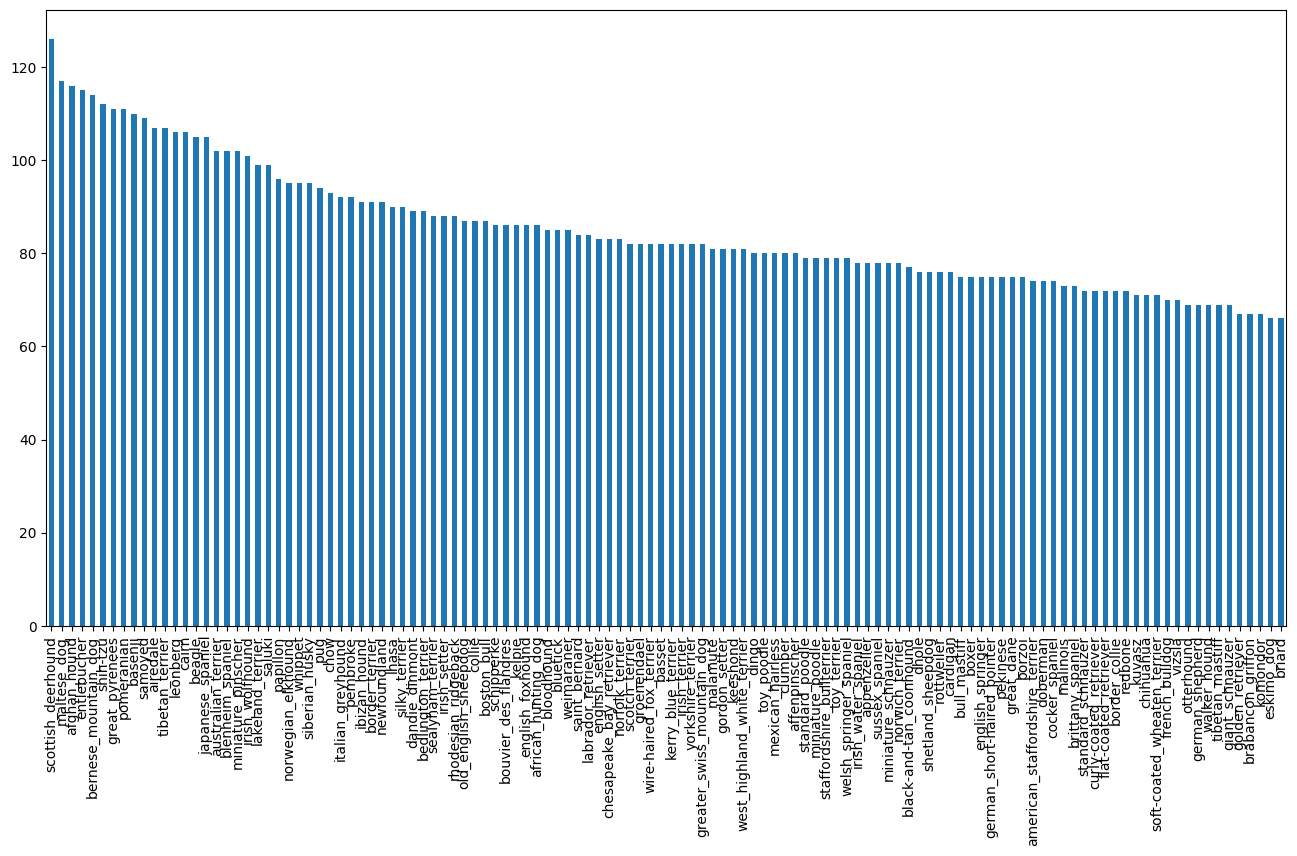

In [8]:
labels['breed'].value_counts().plot.bar(figsize=(16, 8))

In [9]:
# ImageDatagenerator to load the images in batches and perform data augmentation

data_generator = ImageDataGenerator(rescale= 1./255, validation_split=0.2, rotation_range=20,
                                    zoom_range=0.1, width_shift_range=0.2, height_shift_range=0.2,
                                    shear_range=0.1, horizontal_flip=True, fill_mode="nearest")

In [10]:
train_generator = data_generator.flow_from_dataframe(labels, directory=train_dir, x_col='id', y_col='breed', target_size=SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED, subset='training')
val_generator = data_generator.flow_from_dataframe(labels, directory=train_dir, x_col='id', y_col='breed', target_size=SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED, subset='validation')

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


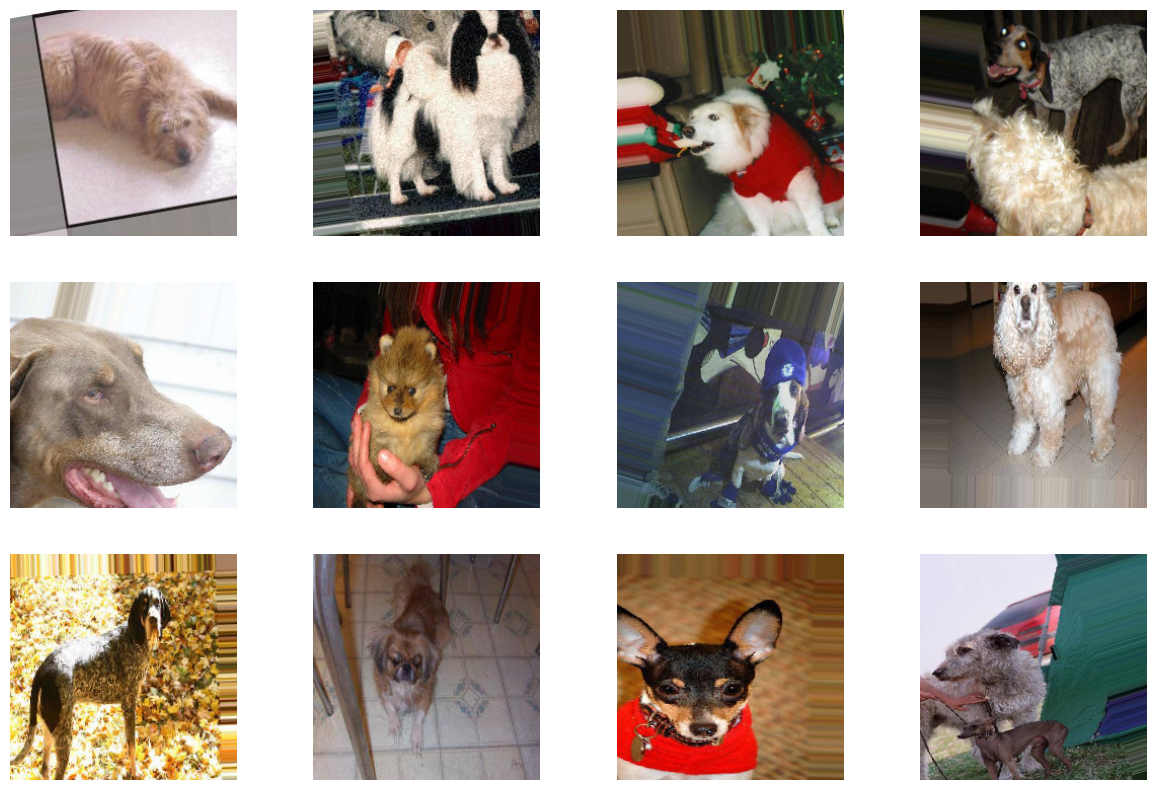

In [11]:
# 12 images after augmentation

img, label = next(train_generator)

fig = plt.figure(figsize=(15, 10))

for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')

# Model

In [12]:
# callbacks that will be used during training

early_stopping = EarlyStopping(monitor='val_loss', mode = 'min', patience=10)
checkpoint = ModelCheckpoint(filepath = './weights.hdf5', verbose=1, save_best_only=True)

In [13]:
base_model = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

base_model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
head_model = AveragePooling2D(pool_size=(4, 4))(base_model.output)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(1024, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(512, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(120, activation='softmax')(head_model)

In [16]:
model = Model(inputs=base_model.input, outputs=head_model)
optimizer = SGD(learning_rate=0.1, momentum=0.9, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

In [18]:
history = model.fit(train_generator, epochs=1, validation_data=val_generator, callbacks=[checkpoint])

256/256 [==============================] - ETA: 0s - loss: 2.7506 - accuracy: 0.4094
Epoch 1: val_loss improved from inf to 1.73184, saving model to ./weights.hdf5
256/256 [==============================] - 1472s 6s/step - loss: 2.7506 - accuracy: 0.4094 - val_loss: 1.7318 - val_accuracy: 0.5959


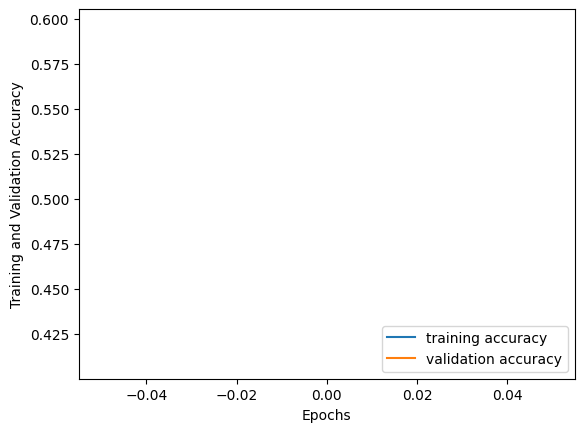

In [19]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(loc='lower right')

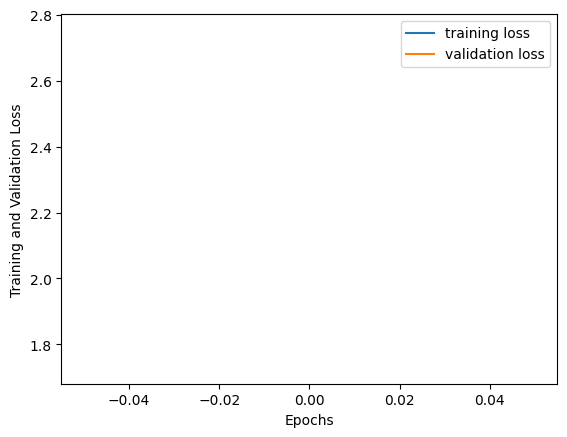

In [20]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()